# BBC News Classification

## —— A Comparison of Unsupervised and Supervised Machine Learning Approaches

## Table of Contents
### 1. Project Background and Data Set Description
### 2. Setting up the Work Environment
### 3. Importing the Data Set
### 4. Exploratory Data Analysis
### 5. Data Preparation
### 6. Unsupervised Model - NMF
### 7. Supervised Model - Naive Bayes
### 8. Summary of Results and Conclusion

<br/>

<h2 style="background-color:DodgerBlue;color:white">1. Project Background and Data Set Description

Text documents are one of the richest sources of data for businesses. In this project we will analyze a news articles data set using an unsupervised method —— Matrix Factorization, and compare its results with a supervised method —— Naive Bayes。

We will use a public data set from the BBC. The data set contains 2225 articles, each labeled under one of 5 news categories: business, entertainment, politics, sport or tech. The dataset is broken into 1490 articles for training and 735 for testing. The goal will be to build a model that can accurately classify previously unseen news articles into the right category.

Our models will be evaluated using Accuracy as the metric.

The data set can be found here: https://www.kaggle.com/competitions/learn-ai-bbc/overview

<br/>

<h2 style="background-color:DodgerBlue;color:white">2. Setting up the Work Environment

In [1]:
# 1. Importing the necessary packages
# 1.1 Data Manipulation and Computations
import pandas as pd
import numpy as np
from collections import Counter

# 1.2 Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [70]:
# 2. Natural Language Processing
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

from keras_preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mding\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mding\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mding\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


In [50]:
# 3. Machine Learning tools
# 3.1 Unsupervised
from sklearn.decomposition import NMF

# 3.2 Supervised
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# 3.3 Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix

<br/>

<h2 style="background-color:DodgerBlue;color:white">3. Importing the data

In [6]:
traind = pd.read_csv(r'C:\Users\mding\Desktop\BBC News Train.csv')
testd = pd.read_csv(r'C:\Users\mding\Desktop\BBC News Test.csv')

In [7]:
traind.head() 
# ArticleID might be useful in submission, but it is not useful for training; also we won't use the category here, because we are doing unsupervised

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [8]:
testd.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


**We can see that all the texts are already in lower case, also that some punctuations such as ' and , have been removed, but not full stops.**

In [9]:
traind.Text[0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

In [10]:
print(traind.shape, testd.shape)

(1490, 3) (735, 2)


In [11]:
# Save the ArticleId from train and test so that we can use them later on
train_id = traind.ArticleId
test_id = testd.ArticleId

# Combining train and test, since we are doing unsupervised
fulld = pd.concat([traind, testd], axis = 0)
print(fulld.shape)

(2225, 3)


<br/>

<h2 style="background-color:DodgerBlue;color:white">4. Exploratory Data Analysis

**We can use WordCloud to visualize our text data:**
- We can already see that the articles contain a lot of stop words, such as "will".
- There are also a lot of general words such as "said", "say", and "now".
- But we can also see some category-related words, such as "player", and "game".

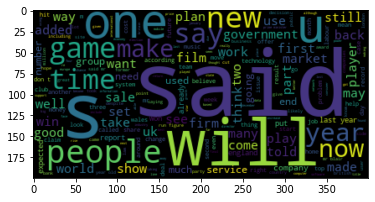

In [12]:
# Let's have a look at the data
txt = " ".join([article for article in fulld.Text]) # turn into a single string
wc = WordCloud().generate(txt)
plt.imshow(wc, interpolation = 'bilinear')

**We can get a more interesting and meaningful visualization by filtering the WordCloud by category.**
- We can see that business contains words such as 'market' and 'company'.
- tech contains words such as 'mobile', 'game' and 'computer'.
- politics contains words such as 'government', 'party', and 'mr. blair'.
- entertainment contains words such as 'film', 'star', and 'show'.
- sports contain words such as 'player', 'win' and 'game.
- However, we can still see a lot of general words such as 'said', 'people' and 'said', this observation will determine how we will clean our data later on.

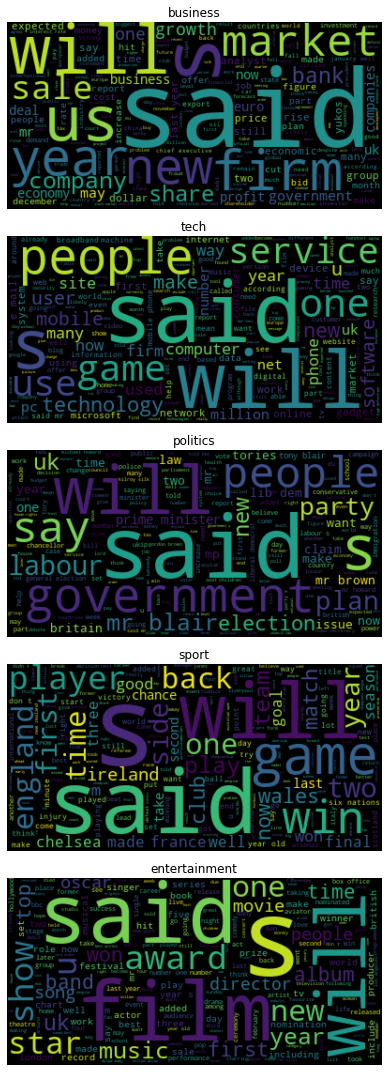

In [17]:
category_names = traind.Category.unique()

fig = plt.figure(figsize = (10,15))
i = 1

for category in category_names:
    fig.add_subplot(5,1,i)
    txt = " ".join([article for article in traind[traind.Category == category].Text])
    wc = WordCloud().generate(txt)
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title(category)
    plt.axis('off')
    plt.tight_layout()
    i+= 1

**The target variable 'Category' seems variable balanced in terms of clss distribution.**

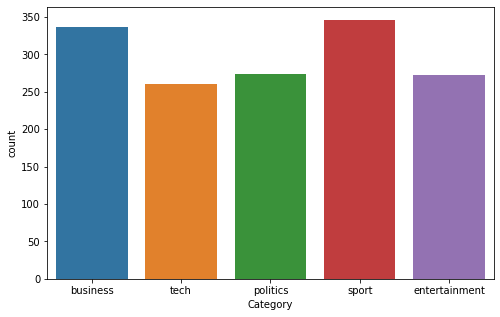

In [191]:
plt.figure(figsize = (8,5))
sns.countplot(x = traind.Category);

<h2 style="background-color:DodgerBlue;color:white">5. Data Preparation

Typical text data cleaning steps include:
1. Text Normalization:
    - Turning all text into a consistent case (lower case for example)
    - Dropping unnecessary punctuations
    - Removing numbers
    - Removing stop words
2. Toeknization:
    - Turning long text into tokens or individual expressions (such as a word)
3. Stemming/Lemmatization:
    - Stemming and Lemmatization serve similar purposes, they both try to group similar words into one. For example, consult, consulting, consultant, consultants will all be turned into consult.
    - The difference is that Stemming is dictionary based, while Lemmatization takes into consideration of contexts (known as tags).
4. Text Vectorization:
    - Text Vectorization is used to turn the data from raw texts into a vectorized numerical representation, which is necessary for computers to process.
    - In this project we will use TF-IDF (term frequency inverse document frequency). Other common text vectorization includes Bag of Words and Word2Vec.
    - We chose to use TF-IDF because based on our previous EDA and visual analysis, we could see that there exists a lot of general words across the target categories. We want to discount those general words and place less weight on them and focus more on words that appear less frequently but only inside a particular category. TF-IDF does exactly this, it essentially says how important is a given word to a given document when constrasted with the frequency of the word occurring across all documents.

Let's write a function to help us do the text cleaning.

In [13]:
def textprocessor(training_text):
        training_text= str(training_text)
        training_tokens = text_to_word_sequence(training_text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = " ")
    
        # removing stop words
        stop_words = set(stopwords.words('english'))
        tokens_nostopwords = [word for word in training_tokens if not word in stop_words]
     
        # joining words into a sentence
        text_nostopwords = ' '.join(tokens_nostopwords)
        
        # removing numbers
        text_nonumbers = ''.join(word for word in text_nostopwords if not word.isdigit())
        
        # Stemming
        stem = SnowballStemmer('english')

        stem_input = nltk.word_tokenize(text_nonumbers)
        text_stem=' '.join([stem.stem(word) for word in stem_input])
        
        return text_stem

In [14]:
# now preprocessing the text
fulld['processed_text'] = fulld['Text'].apply(textprocessor)
fulltrain_text = fulld['processed_text']
fulltrain_text.head()

0    worldcom ex boss launch defenc lawyer defend f...
1    german busi confid slide german busi confid fe...
2    bbc poll indic econom gloom citizen major nati...
3    lifestyl govern mobil choic faster better funk...
4    enron boss m payout eighteen former enron dire...
Name: processed_text, dtype: object

In [15]:
# now we need to turn the processed text into numerical representation for ML
# using tfidf-vectorizor
tfidf = TfidfVectorizer()
fulltrain_tfidf = tfidf.fit_transform(fulltrain_text)

<br/>

<h2 style="background-color:DodgerBlue;color:white">6. Unsupervised Model - NMF

### 6.1.1 Baseline Model (1st Iteration)

In [51]:
# Let's build our base line using default NMF settings
# And n_clusters is set to 5 (or the number of categories we can in the data)
n_clusters = category_names.size

NMF_i1 = NMF(n_components = n_clusters, random_state = 42)
W = NMF_i1.fit_transform(fulltrain_tfidf)

In [52]:
W[:5]

array([[0.        , 0.0350062 , 0.00919569, 0.00344303, 0.05376328],
       [0.        , 0.        , 0.        , 0.        , 0.16647689],
       [0.01438671, 0.03386067, 0.02111079, 0.00105822, 0.08816469],
       [0.        , 0.        , 0.1983961 , 0.        , 0.        ],
       [0.0095086 , 0.00469974, 0.01377508, 0.0192011 , 0.06698821]])

In [53]:
W.argsort()[0:5]

array([[0, 3, 2, 1, 4],
       [0, 1, 2, 3, 4],
       [3, 0, 2, 1, 4],
       [0, 1, 3, 4, 2],
       [1, 0, 2, 3, 4]], dtype=int64)

In [57]:
traind.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [ ]:
# We can see some similarities here

In [21]:
W.argsort()[0:10]

array([[0, 3, 2, 1, 4],
       [0, 1, 2, 3, 4],
       [3, 0, 2, 1, 4],
       [0, 1, 3, 4, 2],
       [1, 0, 2, 3, 4],
       [4, 3, 2, 0, 1],
       [1, 2, 3, 4, 0],
       [2, 4, 0, 1, 3],
       [0, 1, 2, 3, 4],
       [2, 1, 0, 4, 3]], dtype=int64)

In [22]:
traind.head(10)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
5,1582,howard truanted to play snooker conservative...,politics
6,651,wales silent on grand slam talk rhys williams ...,sport
7,1797,french honour for director parker british film...,entertainment
8,2034,car giant hit by mercedes slump a slump in pro...,business
9,1866,fockers fuel festive film chart comedy meet th...,entertainment


In [23]:
# It seems business = 4, tech = 2, politics = 1, sport = 0 and entertainment = 3
# Let's further verify

traind.Category.value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [24]:
labels = []

for row in W.argsort():
    labels.append(row[4])

# remember we should filter the train only
labels_train = labels[0:train_id.shape[0]]

Counter(labels_train).most_common()

[(0, 355), (4, 330), (2, 287), (1, 277), (3, 241)]

In [25]:
# Joining the labels to the DF
labels = pd.DataFrame(data = {'label':labels}, index = fulld.index)

clustered_d = pd.concat([fulld, labels], axis = 1)
clustered_d.head()

,ArticleId,Text,Category,processed_text,label
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom ex boss launch defenc lawyer defend f...,4
1,154,german business confidence slides german busin...,business,german busi confid slide german busi confid fe...,4
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indic econom gloom citizen major nati...,4
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyl govern mobil choic faster better funk...,2
4,917,enron bosses in $168m payout eighteen former e...,business,enron boss m payout eighteen former enron dire...,4


**Manually comparing the mapping between 'Category' and 'label', we can see that they do seem relatively consistant with each other.**

In [91]:
clustered_d.sample(20)

,ArticleId,Text,Category,processed_text,label
1097,1674,mogul wilson backing uk rap band tony wilson ...,entertainment,mogul wilson back uk rap band toni wilson musi...,3
1284,934,mutant book wins guardian prize a book about t...,entertainment,mutant book win guardian prize book evolut mut...,3
626,1084,off-colour gardener storms to win britain s ja...,NaN,colour garden storm win britain jason garden s...,0
436,2202,ban on forced retirement under 65 employers wi...,NaN,ban forc retir employ longer abl forc worker r...,1
263,2151,spain coach faces racism inquiry spain s footb...,sport,spain coach face racism inquiri spain footbal ...,0
1050,250,keanu reeves given hollywood star actor keanu ...,entertainment,keanu reev given hollywood star actor keanu re...,3
186,61,telegraph newspapers axe 90 jobs the daily and...,business,telegraph newspap axe job daili sunday telegra...,4
302,435,s korean lender faces liquidation creditors of...,business,korean lender face liquid creditor south korea...,4
381,1793,worldcom bosses $54m payout ten former direct...,business,worldcom boss m payout ten former director wor...,4
1084,2219,davies favours gloucester future wales hooker ...,sport,davi favour gloucest futur wale hooker mefin d...,0


### 6.1.2 Baseline Model Evaluation on Train Set

In [32]:
# Setting up a label_dictionary
class_labels = ['sport', 'politics', 'tech', 'entertainment', 'business']
label_dictionary = {k:v for k,v in enumerate(class_labels)}
label_dictionary

{0: 'sport', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'business'}

In [34]:
# Evaluation on training set
train_prediction = clustered_d.set_index('ArticleId').loc[train_id.values]
train_prediction['Predicted_Category'] = train_prediction.label.replace(label_dictionary)
train_prediction.head()

,Text,Category,processed_text,label,Predicted_Category
ArticleId,,,,,
1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom ex boss launch defenc lawyer defend f...,4,business
154,german business confidence slides german busin...,business,german busi confid slide german busi confid fe...,4,business
1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indic econom gloom citizen major nati...,4,business
1976,lifestyle governs mobile choice faster bett...,tech,lifestyl govern mobil choic faster better funk...,2,tech
917,enron bosses in $168m payout eighteen former e...,business,enron boss m payout eighteen former enron dire...,4,business


**Based on the classification report and confusion matrix, we can see that our baseline model does pretty well. Overall, it achieves an accuracy of 93%. And it does particularly well on 'sports' achieving an F1-Score of 98%, it does the worst on 'entertainment' and 'tech' at 90% F1-Score.**

In [36]:
print(classification_report(train_prediction.Category, train_prediction.Predicted_Category))

               precision    recall  f1-score   support

     business       0.94      0.92      0.93       336
entertainment       0.96      0.85      0.90       273
     politics       0.92      0.93      0.93       274
        sport       0.96      0.99      0.98       346
         tech       0.86      0.94      0.90       261

     accuracy                           0.93      1490
    macro avg       0.93      0.93      0.93      1490
 weighted avg       0.93      0.93      0.93      1490



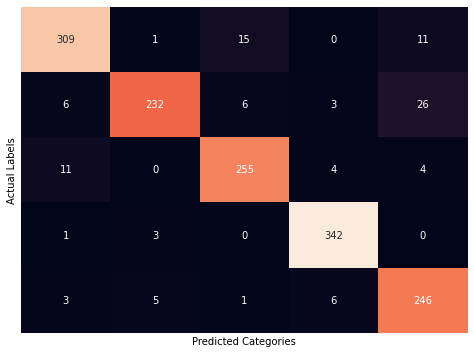

In [44]:
plt.figure(figsize = (8,6))
cm = confusion_matrix(train_prediction.Category, train_prediction.Predicted_Category)
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False, xticklabels= False, yticklabels= False)
plt.xlabel('Predicted Categories')
plt.ylabel('Actual Labels');

### 6.1.3 Baseline Model Evaluation on Test Set

In [127]:
# Evaluation on the test set
test_prediction = clustered_d.set_index('ArticleId').loc[test_id.values]
test_prediction['Category'] = test_prediction.label.replace(label_dictionary)

In [120]:
test_prediction

,Text,Category,processed_text,label
ArticleId,,,,
1018,qpr keeper day heads for preston queens park r...,sport,qpr keeper day head preston queen park ranger ...,0
1319,software watching while you work software that...,tech,softwar watch work softwar monitor everi keyst...,2
1138,d arcy injury adds to ireland woe gordon d arc...,sport,arci injuri add ireland woe gordon arci rule i...,0
459,india s reliance family feud heats up the ongo...,business,india relianc famili feud heat ongo public spa...,4
1020,boro suffer morrison injury blow middlesbrough...,sport,boro suffer morrison injuri blow middlesbrough...,0
...,...,...,...,...
1923,eu to probe alitalia state aid the european ...,business,eu probe alitalia state aid european commiss o...,4
373,u2 to play at grammy awards show irish rock ba...,entertainment,u play grammi award show irish rock band u pla...,3
1704,sport betting rules in spotlight a group of mp...,tech,sport bet rule spotlight group mps peer call t...,2


**On the test set, our model achieves an accuracy score of 93.7%, which is consistent with our accuracy on training set.**

In [128]:
# Note in the sample submission file there are only 2 columns
# articleid and category
test_prediction.reset_index(inplace = True)
submission = test_prediction.loc[:,['ArticleId','Category']]
submission.to_csv(r'C:\Users\mding\Desktop\BBC News mysubmission.csv', index = False)

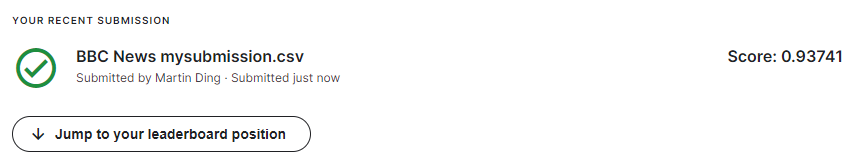

### 6.2.1 Attempt to Improving Results (2nd Iteration)

**Previously we used stemming to clean our data, here let's try lemmatization to see if it can help us improve model performance**

Let's first define a processor that uses lemmatization.

In [71]:
def textprocessor_i2(training_text):
        training_text= str(training_text)
        training_tokens = text_to_word_sequence(training_text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = " ")
    
        # removing stop words
        stop_words = set(stopwords.words('english'))
        tokens_nostopwords = [word for word in training_tokens if not word in stop_words]
     
        # joining words into a sentence
        text_nostopwords = ' '.join(tokens_nostopwords)
        
        # removing numbers
        text_nonumbers = ''.join(word for word in text_nostopwords if not word.isdigit())
        
        # Lemmatization
        lemmatizer = WordNetLemmatizer()

        def get_wordnet_pos(word):
            """Map POS tag to first character lemmatize() accepts"""
            tag = nltk.pos_tag([word])[0][1][0].upper()
            tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

            return tag_dict.get(tag, wordnet.NOUN)

        lem_input = nltk.word_tokenize(text_nonumbers)
        text_lem = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])
        
        return text_lem

In [72]:
fulld_i2 = fulld.copy()
fulld_i2['processed_text'] = fulld_i2['Text'].apply(textprocessor_i2)
# Note lemmatizer takes a bit longer to run, it is more computationally expensive
fulltrain_text_i2 = fulld_i2['processed_text']
fulltrain_text_i2.head()

0    worldcom ex bos launch defence lawyer defend f...
1    german business confidence slide german busine...
2    bbc poll indicates economic gloom citizen majo...
3    lifestyle governs mobile choice faster well fu...
4    enron boss m payout eighteen former enron dire...
Name: processed_text, dtype: object

In [73]:
fulltrain_tfidf_i2 = tfidf.fit_transform(fulltrain_text_i2)

# retraining using iteration 2
NMF_i2 = NMF(n_components = n_clusters, random_state = 42)
W_i2 = NMF_i2.fit_transform(X = fulltrain_tfidf_i2)

In [90]:
labels_i2 = []

for row in W_i2.argsort():
    labels_i2.append(row[4])

# remember we should filter the train only
labels_train_i2 = labels_i2[0:train_id.shape[0]]

Counter(labels_train_i2).most_common()

[(0, 355), (4, 326), (2, 284), (1, 282), (3, 243)]

In [91]:
# Joining the labels to the DF
labels_i2 = pd.DataFrame(data = {'label':labels_i2}, index = fulld.index)

clustered_d2 = pd.concat([fulld, labels_i2], axis = 1)
clustered_d2.head()

,ArticleId,Text,Category,processed_text,label
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom ex boss launch defenc lawyer defend f...,4
1,154,german business confidence slides german busin...,business,german busi confid slide german busi confid fe...,4
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indic econom gloom citizen major nati...,4
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyl govern mobil choic faster better funk...,2
4,917,enron bosses in $168m payout eighteen former e...,business,enron boss m payout eighteen former enron dire...,4


### 6.2.2 Second Iteration's Evaluation on Train Set

In [92]:
# Evaluation on training set
train_prediction_i2 = clustered_d2.set_index('ArticleId').loc[train_id.values]
train_prediction_i2['Predicted_Category'] = train_prediction_i2.label.replace(label_dictionary)
train_prediction_i2.head()

,Text,Category,processed_text,label,Predicted_Category
ArticleId,,,,,
1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom ex boss launch defenc lawyer defend f...,4,business
154,german business confidence slides german busin...,business,german busi confid slide german busi confid fe...,4,business
1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indic econom gloom citizen major nati...,4,business
1976,lifestyle governs mobile choice faster bett...,tech,lifestyl govern mobil choic faster better funk...,2,tech
917,enron bosses in $168m payout eighteen former e...,business,enron boss m payout eighteen former enron dire...,4,business


In [93]:
train_prediction_i2.sample(30)

,Text,Category,processed_text,label,Predicted_Category
ArticleId,,,,,
550,berlin celebrates european cinema organisers s...,entertainment,berlin celebr european cinema organis say year...,3,entertainment
295,china net cafe culture crackdown chinese autho...,tech,china net cafe cultur crackdown chines author ...,2,tech
1765,nintendo ds aims to touch gamers the mobile ga...,tech,nintendo ds aim touch gamer mobil game industr...,2,tech
1008,child access law shake-up planned parents who ...,politics,child access law shake plan parent refus allow...,1,politics
891,wales win in rome wales secured their first aw...,sport,wale win rome wale secur first away win rbs si...,0,sport
655,asylum children to face returns the uk governm...,politics,asylum children face return uk govern plan ret...,1,politics
1999,cannabis hopes for drug firm a prescription ca...,business,cannabi hope drug firm prescript cannabi drug ...,4,business
1506,rover deal may cost 2 000 jobs some 2 000 jo...,business,rover deal may cost job job mg rover midland p...,4,business
20,games maker fights for survival one of britain...,tech,game maker fight surviv one britain largest in...,4,business


**Based on the classification report and confusion matrix, we can see that our second model does pretty well. Overall, it achieves an accuracy of 93%, which is consistent with our previous model. And it does particularly well on 'sports' achieving an F1-Score of 98%, it does the worst on 'entertainment' and 'tech' at 90% F1-Score. Our stemmer-based model and lemmatizer-based model seem to have similar results on the training set.**

In [94]:
print(classification_report(train_prediction_i2.Category, train_prediction_i2.Predicted_Category))

               precision    recall  f1-score   support

     business       0.95      0.92      0.93       336
entertainment       0.95      0.85      0.90       273
     politics       0.91      0.94      0.92       274
        sport       0.96      0.99      0.98       346
         tech       0.86      0.93      0.90       261

     accuracy                           0.93      1490
    macro avg       0.93      0.93      0.93      1490
 weighted avg       0.93      0.93      0.93      1490



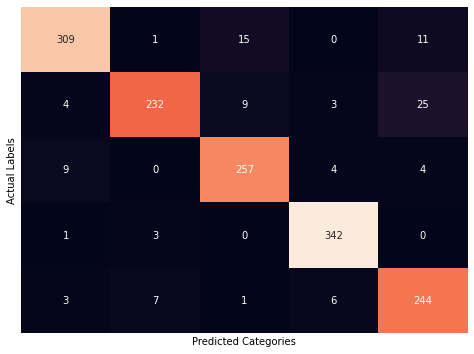

In [95]:
plt.figure(figsize = (8,6))
cm = confusion_matrix(train_prediction_i2.Category, train_prediction_i2.Predicted_Category)
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False, xticklabels= False, yticklabels= False)
plt.xlabel('Predicted Categories')
plt.ylabel('Actual Labels');

### 6.2.3 Second Iteration's Evaluation on Test Set

**On the test set, our model achieves an accuracy score of 93.1%, which is consistent with our accuracy on training set, but it is slightly worse than our previous stemmer-based model.**

In [96]:
# Evaluation in test set
test_prediction_i2 = clustered_d2.set_index('ArticleId').loc[test_id.values]
test_prediction_i2['Category'] = test_prediction_i2.label.replace(label_dictionary)

# Note in the sample submission file there are only 2 columns
# articleid and category
test_prediction_i2.reset_index(inplace = True)
submission_i2 = test_prediction_i2.loc[:,['ArticleId','Category']]
submission_i2.to_csv(r'C:\Users\mding\Desktop\BBC News mysubmission_i2.csv', index = False)

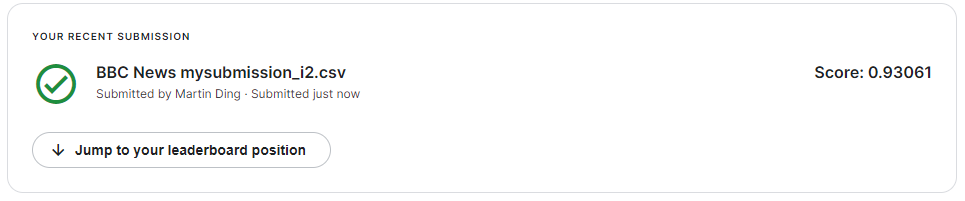

### 6.3.1 Attempt to Improving Results (3rd Iteration)

In the third iteration, let's try a different loss function, the KL loss. Note we cannot use the coordinate gradient descent solver if we use the KL loss, so we will set solver to 'mu'.

In [100]:
fulltrain_tfidf_i3 = fulltrain_tfidf.copy() # here we are using the stemmer version
NMF_i3 = NMF(n_components = n_clusters, solver = 'mu', beta_loss = 'kullback-leibler', random_state = 42)
W_i3 = NMF_i3.fit_transform(fulltrain_tfidf_i3)

In [101]:
labels_i3 = []

for row in W_i3.argsort():
    labels_i3.append(row[4])

# remember we should filter the train only
labels_train_i3 = labels_i3[0:train_id.shape[0]]

Counter(labels_train_i3).most_common()

[(0, 381), (2, 294), (1, 274), (3, 274), (4, 267)]

In [102]:
traind.Category.value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [103]:
# Joining the labels to the DF
labels_i3 = pd.DataFrame(data = {'label':labels_i3}, index = fulld.index)

clustered_d3 = pd.concat([fulld, labels_i3], axis = 1)
clustered_d3.head()

,ArticleId,Text,Category,processed_text,label
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom ex boss launch defenc lawyer defend f...,1
1,154,german business confidence slides german busin...,business,german busi confid slide german busi confid fe...,4
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indic econom gloom citizen major nati...,4
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyl govern mobil choic faster better funk...,2
4,917,enron bosses in $168m payout eighteen former e...,business,enron boss m payout eighteen former enron dire...,4


### 6.3.2 Third Iteration's Evaluation on Train Set

In [104]:
# Evaluation on training set
train_prediction_i3 = clustered_d3.set_index('ArticleId').loc[train_id.values]
train_prediction_i3['Predicted_Category'] = train_prediction_i3.label.replace(label_dictionary)
train_prediction_i3.head()

,Text,Category,processed_text,label,Predicted_Category
ArticleId,,,,,
1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom ex boss launch defenc lawyer defend f...,1,politics
154,german business confidence slides german busin...,business,german busi confid slide german busi confid fe...,4,business
1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indic econom gloom citizen major nati...,4,business
1976,lifestyle governs mobile choice faster bett...,tech,lifestyl govern mobil choic faster better funk...,2,tech
917,enron bosses in $168m payout eighteen former e...,business,enron boss m payout eighteen former enron dire...,4,business


In [105]:
train_prediction_i3.sample(30)

,Text,Category,processed_text,label,Predicted_Category
ArticleId,,,,,
2080,holmes starts 2005 with gb events kelly holmes...,sport,holm start gb event kelli holm start seri race...,0,sport
1613,blair rejects tory terror offer tony blair has...,politics,blair reject tori terror offer toni blair reje...,1,politics
1052,uk helps raped rwandan women britain is to giv...,politics,uk help rape rwandan women britain give £m gra...,3,entertainment
2107,us trade deficit widens sharply the gap betwee...,business,us trade deficit widen sharpli gap us export i...,4,business
831,chelsea hold arsenal a gripping game between a...,sport,chelsea hold arsenal grip game arsenal chelsea...,0,sport
840,format wars could confuse users technology f...,tech,format war could confus user technolog firm so...,2,tech
834,wenger offers mutu hope arsenal boss arsene we...,sport,wenger offer mutu hope arsenal boss arsene wen...,0,sport
292,freeze on anti-spam campaign a campaign by lyc...,tech,freez anti spam campaign campaign lyco europ t...,2,tech
1192,jones files lawsuit against conte marion jones...,sport,jone file lawsuit cont marion jone file lawsui...,0,sport


**Based on the classification report and confusion matrix, we can see that our 3rd model performed worse than the baseline. Overall, it achieves an accuracy of 91%. And it does particularly well on 'entertainment' achieving an F1-Score of 95%, it does the worst on 'tech' at 86% F1-Score.**

In [106]:
print(classification_report(train_prediction_i3.Category, train_prediction_i3.Predicted_Category))

               precision    recall  f1-score   support

     business       0.97      0.77      0.86       336
entertainment       0.95      0.96      0.95       273
     politics       0.92      0.92      0.92       274
        sport       0.89      0.98      0.93       346
         tech       0.81      0.91      0.86       261

     accuracy                           0.91      1490
    macro avg       0.91      0.91      0.91      1490
 weighted avg       0.91      0.91      0.91      1490



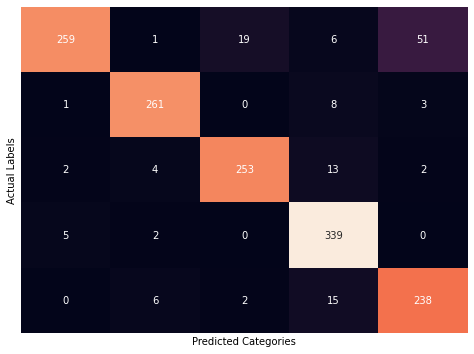

In [107]:
plt.figure(figsize = (8,6))
cm = confusion_matrix(train_prediction_i3.Category, train_prediction_i3.Predicted_Category)
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False, xticklabels= False, yticklabels= False)
plt.xlabel('Predicted Categories')
plt.ylabel('Actual Labels');

### 6.3.3 Third Iteration's Evaluation on Train Set

**With a 92.1% accuracy, our third model is worse than the baseline model**.

In [108]:
# Evaluation on test set
test_prediction_i3 = clustered_d3.set_index('ArticleId').loc[test_id.values]
test_prediction_i3['Category'] = test_prediction_i3.label.replace(label_dictionary)

# Note in the sample submission file there are only 2 columns
# articleid and category
test_prediction_i3.reset_index(inplace = True)
submission_i3 = test_prediction_i3.loc[:,['ArticleId','Category']]
submission_i3.to_csv(r'C:\Users\mding\Desktop\BBC News mysubmission_i3.csv', index = False)

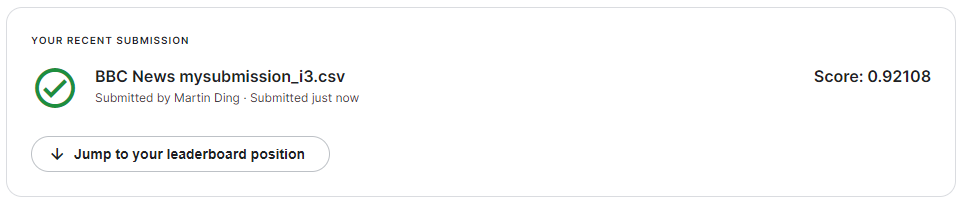

### 6.4 Summary of Matrix Factorization Results

| Model | Accuracy on Train Set | Accuracy on Test Set|
|-------|-----------------------|---------------------|
|NMF with **'cd'** solver and **'frobenius'** loss function and **stemming** for preprocessing|93.0%|93.7%| 
|NMF with **'cd'** solver and **'frobenius'** loss function and **lemmatizing** for preprocessing|93.0%|93.1%| 
|NMF with **'mu'** solver and **'kullback-leibler'** loss function and **stemming** for preprocessing|91.0%|92.1%| 

<br/>

<h2 style="background-color:DodgerBlue;color:white"> 7. Supervised Model - Naive Bayes

We choose to apply a Naive Bayes Model, as NB models are simple and fast to run, but have relatively good performance on text data. In particular we will use a MultinomialNB rather than GaussianNB. A multinomial distribution is useful to model feature vectors where each value represents, for example, the number of occurrences of a term or its relative frequency, which is precisely what our data representation is like. On the other hand, the GaussianNB is more suitable when the data follows a continuous Gaussian distribution.


### 7.1 Naive Bayes on Full Training Data

In [128]:
# Preparing the data
X_train = fulltrain_text.iloc[traind.index]
y_train = traind.Category

In [129]:
print(X_train.shape, y_train.shape)

(1490,) (1490,)


**We will build a pipeline to process, train and tune hyperparameters**

In [133]:
nb_clf = Pipeline([('tfidf', TfidfVectorizer()),
                   ('classifier', MultinomialNB()),
                  ])

params = {
         'classifier__alpha': np.linspace(0.5, 1.5, 6),
         'classifier__fit_prior': [True, False],    
         'tfidf__max_df': np.linspace(0.1, 1, 10),
         'tfidf__binary': [True, False],
         'tfidf__norm': [None, 'l1', 'l2']
         }

nb_hypertune = GridSearchCV(estimator = nb_clf,
                            param_grid = params,
                            cv = 5,
                            verbose = 1,
                            scoring = 'accuracy')

nb_hypertune.fit(X_train, y_train)

print("Best Score: ", nb_hypertune.best_score_)
print("Best Params: ", nb_hypertune.best_params_)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed: 17.8min finished


Best Score:  0.9758389261744966
Best Params:  {'classifier__alpha': 0.5, 'classifier__fit_prior': False, 'tfidf__binary': False, 'tfidf__max_df': 0.4, 'tfidf__norm': 'l2'}


In [146]:
X_test = testd['Text'].apply(textprocessor)
X_test.shape

(735,)

In [149]:
test_predictions_sup = nb_hypertune.predict(X_test)
test_predictions_sup[:5]

array(['sport', 'tech', 'sport', 'business', 'sport'], dtype='<U13')

**We can see that our model results in a training set accuracy of 97.6% and a test set accuracy of 96.7%, both are higher than the unsupervised results, as we should expect.**

In [155]:
# Evaluation in test set
pred_sup = pd.DataFrame({'Category':test_predictions_sup})
submission_sup = pd.concat([testd, pred_sup], axis = 1)
submission_sup.to_csv(r'C:\Users\mding\Desktop\BBC News mysubmission_sup.csv', index = False)
submission_sup.head()

,ArticleId,Text,Category
0,1018,qpr keeper day heads for preston queens park r...,sport
1,1319,software watching while you work software that...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport


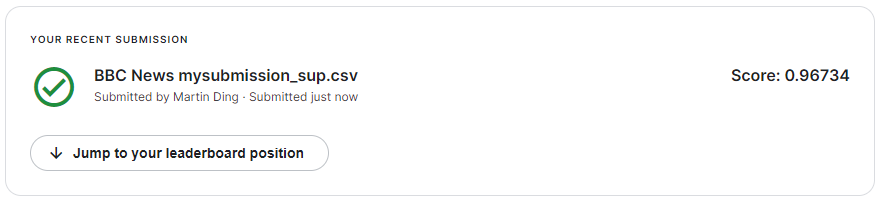

### 7.1 Naive Bayes on 50% Training Data

In [173]:
# now just sample 50% of the data
halfdata_idx = traind.sample(int(0.5*traind.shape[0]), random_state = 42).index
X_train_50 = fulltrain_text.iloc[halfdata_idx]
y_train_50 = traind.iloc[halfdata_idx].Category
print(X_train_50.shape, y_train_50.shape)

(745,) (745,)


In [174]:
nb_clf = Pipeline([('tfidf', TfidfVectorizer()),
                   ('classifier', MultinomialNB()),
                  ])

params = {
         'classifier__alpha': np.linspace(0.5, 1.5, 6),
         'classifier__fit_prior': [True, False],    
         'tfidf__max_df': np.linspace(0.1, 1, 10),
         'tfidf__binary': [True, False],
         'tfidf__norm': [None, 'l1', 'l2']
         }

nb_hypertune = GridSearchCV(estimator = nb_clf,
                            param_grid = params,
                            cv = 5,
                            verbose = 1,
                            scoring = 'accuracy')

nb_hypertune.fit(X_train_50, y_train_50)

print("Best Score: ", nb_hypertune.best_score_)
print("Best Params: ", nb_hypertune.best_params_)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score:  0.9771812080536912
Best Params:  {'classifier__alpha': 1.1, 'classifier__fit_prior': False, 'tfidf__binary': False, 'tfidf__max_df': 0.2, 'tfidf__norm': 'l2'}


[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:  8.5min finished


In [175]:
test_predictions_sup_50 = nb_hypertune.predict(X_test)
test_predictions_sup_50[:5]

array(['sport', 'tech', 'sport', 'business', 'sport'], dtype='<U13')

**We can see that our model results in a training set accuracy of 97.7% and a test set accuracy of 96.6%. We can see that Training accuracy increased from previously, but test accuracy dropped slightly. This is a classic sign of model overfitting.**

In [176]:
# Evaluation in test set
pred_sup_50 = pd.DataFrame({'Category':test_predictions_sup_50})
submission_sup_50 = pd.concat([testd, pred_sup_50], axis = 1)
submission_sup_50.to_csv(r'C:\Users\mding\Desktop\BBC News mysubmission_sup_50.csv', index = False)
submission_sup_50.head()

,ArticleId,Text,Category
0,1018,qpr keeper day heads for preston queens park r...,sport
1,1319,software watching while you work software that...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport


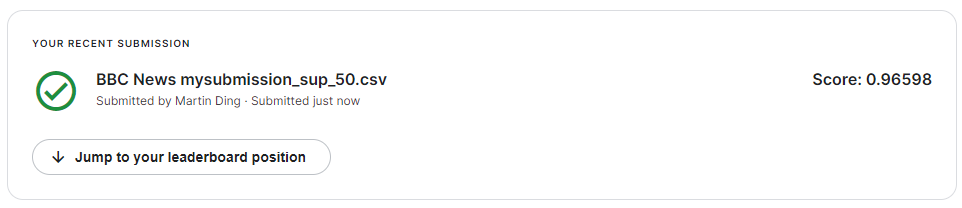

### 7.3 Naive Bayes on 20% Training Data

In [177]:
# now just 20% of data
twentydata_idx = traind.sample(int(0.2*traind.shape[0]), random_state = 42).index
X_train_20 = fulltrain_text.iloc[twentydata_idx]
y_train_20 = traind.iloc[twentydata_idx].Category
print(X_train_20.shape, y_train_20.shape)

(298,) (298,)


In [178]:
nb_clf = Pipeline([('tfidf', TfidfVectorizer()),
                   ('classifier', MultinomialNB()),
                  ])

params = {
         'classifier__alpha': np.linspace(0.5, 1.5, 6),
         'classifier__fit_prior': [True, False],    
         'tfidf__max_df': np.linspace(0.1, 1, 10),
         'tfidf__binary': [True, False],
         'tfidf__norm': [None, 'l1', 'l2']
         }

nb_hypertune = GridSearchCV(estimator = nb_clf,
                            param_grid = params,
                            cv = 5,
                            verbose = 1,
                            scoring = 'accuracy')

nb_hypertune.fit(X_train_20, y_train_20)

print("Best Score: ", nb_hypertune.best_score_)
print("Best Params: ", nb_hypertune.best_params_)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score:  0.9630508474576273
Best Params:  {'classifier__alpha': 0.5, 'classifier__fit_prior': False, 'tfidf__binary': True, 'tfidf__max_df': 0.1, 'tfidf__norm': 'l2'}


[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:  4.1min finished


In [179]:
test_predictions_sup_20 = nb_hypertune.predict(X_test)
test_predictions_sup_20[:5]

array(['sport', 'tech', 'sport', 'business', 'sport'], dtype='<U13')

**We can see that our model results in a training set accuracy of 96.3% and a test set accuracy of 94.4%. We can see that using only 20% of the training examples, our model's performance on both train and test sets dropped significantly. This suggests that the deficiency in training examples is really costing the model's performance.**

In [180]:
# Evaluation in test set
pred_sup_20 = pd.DataFrame({'Category':test_predictions_sup_20})
submission_sup_20 = pd.concat([testd, pred_sup_20], axis = 1)
submission_sup_20.to_csv(r'C:\Users\mding\Desktop\BBC News mysubmission_sup_20.csv', index = False)
submission_sup_20.head()

,ArticleId,Text,Category
0,1018,qpr keeper day heads for preston queens park r...,sport
1,1319,software watching while you work software that...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport


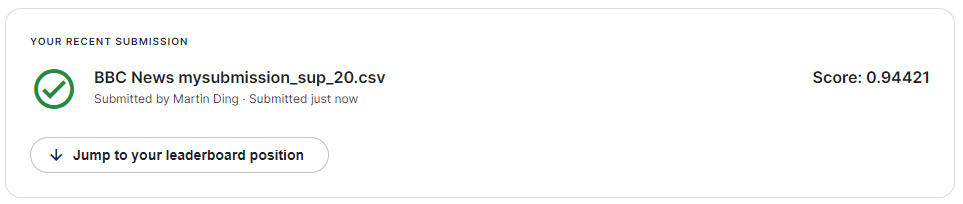

### 7.4 Naive Bayes on 10% Training Data

In [183]:
# now just 10% of data
tendata_idx = traind.sample(int(0.1*traind.shape[0]), random_state = 42).index
X_train_10 = fulltrain_text.iloc[tendata_idx]
y_train_10 = traind.iloc[tendata_idx].Category
print(X_train_10.shape, y_train_10.shape)

(149,) (149,)


In [184]:
nb_clf = Pipeline([('tfidf', TfidfVectorizer()),
                   ('classifier', MultinomialNB()),
                  ])

params = {
         'classifier__alpha': np.linspace(0.5, 1.5, 6),
         'classifier__fit_prior': [True, False],    
         'tfidf__max_df': np.linspace(0.1, 1, 10),
         'tfidf__binary': [True, False],
         'tfidf__norm': [None, 'l1', 'l2']
         }

nb_hypertune = GridSearchCV(estimator = nb_clf,
                            param_grid = params,
                            cv = 5,
                            verbose = 1,
                            scoring = 'accuracy')

nb_hypertune.fit(X_train_10, y_train_10)

print("Best Score: ", nb_hypertune.best_score_)
print("Best Params: ", nb_hypertune.best_params_)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score:  0.9733333333333334
Best Params:  {'classifier__alpha': 0.5, 'classifier__fit_prior': False, 'tfidf__binary': True, 'tfidf__max_df': 0.1, 'tfidf__norm': 'l2'}


[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:  2.2min finished


In [185]:
test_predictions_sup_10 = nb_hypertune.predict(X_test)
test_predictions_sup_10[:5]

array(['sport', 'tech', 'sport', 'business', 'sport'], dtype='<U13')

**We can see that our model results in a training set accuracy of 97.3% and a test set accuracy of 92.8%. We can see that using only 10% of the training examples, our model's performance is high on the train set, but much lower on the test set. This indicates that we have an overfitting problem.**

In [186]:
# Evaluation on test set
pred_sup_10 = pd.DataFrame({'Category':test_predictions_sup_10})
submission_sup_10 = pd.concat([testd, pred_sup_10], axis = 1)
submission_sup_10.to_csv(r'C:\Users\mding\Desktop\BBC News mysubmission_sup_10.csv', index = False)
submission_sup_10.head()

,ArticleId,Text,Category
0,1018,qpr keeper day heads for preston queens park r...,sport
1,1319,software watching while you work software that...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport


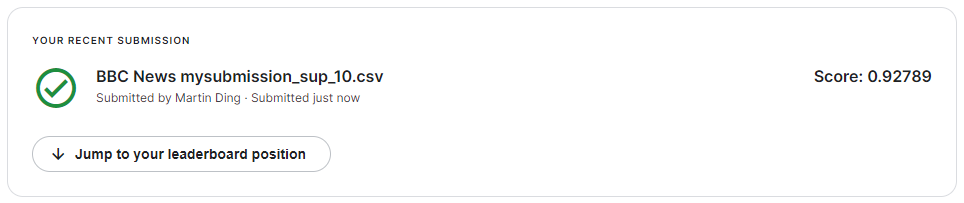

<h2 style="background-color:DodgerBlue;color:white"> 8. Summary of Results and Conclusion

| Model | Accuracy on Train Set | Accuracy on Test Set|
|-------|-----------------------|---------------------|
|NMF with **'cd'** solver and **'frobenius'** loss function and **stemming** for preprocessing|93.0%|93.7%| 
|NMF with **'cd'** solver and **'frobenius'** loss function and **lemmatizing** for preprocessing|93.0%|93.1%| 
|NMF with **'mu'** solver and **'kullback-leibler'** loss function and **stemming** for preprocessing|91.0%|92.1%| 
|Multinomial Naive Bayes with **100% training data**|97.6%|96.7%| 
|Multinomial Naive Bayes with **50% training data**|97.7%|96.6%| 
|Multinomial Naive Bayes with **20% training data**|96.3%|94.4%| 
|Multinomial Naive Bayes with **10% training data**|97.3%|92.8%| 

As we can see based on our summary table:
1. The best performing model is Multinominal Naive Bayes with 100% training data. This model has the highest Accuracy on the test set, and there is no evidence of overfitting. This is not a surprising result as supervised machine learning tends to outperform unsupervised methods when there is sufficient labelled data.
2. Supervised machine learning methods are not as data-efficient as unsupervised approaches such as NMF. We can clearly observe the decrease in performance on the test set when we reduce the training labels available for the Multinominal Naive Bayes model. The performance of the supervised model dropped from 96.7% on 100% data to 92.8% on 10% data, which is actually worse than the best NMF model.
3. We can also see that as we reduce the labelled training data, the supervised model's training set remains high at 97%, but test set performance kept decreasing. This observation suggests that there's an increasing overfitting problem as we reduce training data for supervised models.
4. In comparison, since unsupervised models don't need labels, reducing the label will not affect its performance.